# Which Player Attributes Make A Good Footballer?

In the previous notebook we looked at tree algorithms and how they can be used for classification. **Random forests** are also very useful to extract the most important features in a dataset. This is very helpful when we are dealing with a very large feature space. So in this notebook we will look at how we can perform feature selection using random forests.

![Random_Forest](https://github.com/James-Leslie/Learning-Library/blob/master/Image-repository/random_forest.png?raw=TRUE)

## What's so *random* about this forest?
Let's look at how the random forest algorithm works at a high level:
 * Let's say we have a dataset with $N$ observations and $P$ predictors
 * Grow many trees to create the 'forest'
 * For each tree: 
    * use a randomly chosen subset $n$ of the sample size, where $n < N$
    * use only $p$ randomnly chosen predictors, where $p < P$
    
When making decisions, random forests use either the majority class for classification, or the average value from all decision trees in regression problems.

## Why feature selection?

Machine learning works on a simple rule – the quality of the output depends on the quality of the input (data).

This becomes even more important when the number of features are very large. You don't need to use every feature for creating an algorithm. You can assist your algorithm by feeding in only those features that are really important.

Top reasons to use feature selection are:

* It enables the machine learning algorithm to train faster.
* It reduces the complexity of a model and makes it easier to interpret.
* It improves the accuracy of a model if the right subset is chosen.
* It reduces overfitting.

## How does a random forest perform feature selection?
In training a decision tree, we begin with all of our training data at the root node and then partition the data into smaller subsets which form the 'branches' of the tree.

When partitioning the data at each node, two questions need to be answered:

1. which predictor variable should be used as the split criterion?
2. what value of the predictor variable should be used as the splitting point?   

Partitioning happens at each node in the tree using an algorithm known as **recursive binary splitting** which uses the following logic:

1. Consider all possible predictor variables
  - Consider all possible splits for each variable
2. Select predictor and split based on best separation of data*
3. Divide data into 2 subsets based on the selected split
4. Repeat steps 1-3 for all subsets until some desired ending criteria has been reached

\*the best separation in the data is determined by the split point which results in the lowest variation in the data on either side of the split point. In regression, the variation on either side of the split point is measured by the MSE. 

For classification, the [Gini impurity index](http://dni-institute.in/blogs/cart-decision-tree-gini-index-explained/) is used to determine the best split point.

![split1](https://github.com/James-Leslie/Learning-Library/blob/master/ML%20for%20Actuaries/3_Tree-Based_Regression/splitting_1.png?raw=TRUE)

![split2](https://github.com/James-Leslie/Learning-Library/blob/master/ML%20for%20Actuaries/3_Tree-Based_Regression/splitting_2.png?raw=TRUE)

## Feature selection using the FIFA 2018 players dataset

Let's use the the FIFA 2018 players dataset to select the most important features to predict the overall rating of a forward. We start by importing some libraries.

In [0]:
# imports
from sqlalchemy import create_engine
import psycopg2

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#connect to the sql dataset on AWS 
db_settings = {'host' : 'edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com', 'dbname' : 'edsaLeagueSoccerDatabase', 'user' : 'edsaSoccer', 'password' : 'edsaSoccer'} 
conn_string = ' '.join(["{}='{}'".format(k, v) for k, v in db_settings.items()]) 
print (conn_string)
conn_rds = psycopg2.connect(conn_string) 
print('Created connection')

players = pd.read_sql_query("select * from players", con=conn_rds) 
players.head()

C:\Users\jlesl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We write the same function as in the previous notebook to get the position of the player.

In [0]:
def position_type(s):
    
    """"This function converts the individual positions (abbreviations) and classfies it
    as either a forward, midfielder, back or goal keeper"""
    
    if (s[-2] == 'T') | (s[-2] == 'W') | (s[-2] == 'F'):
        return 'Forward'
    elif s[-2] == 'M':
        return 'Midfielder'
    elif s[-2] == 'B':
        return 'Back'
    else:
        return 'GoalKeeper'

    
# Group players into Forward, Midfielder, Back and GoalKeeper
players['Preferred Positions Type'] = players['Preferred Positions'].apply(lambda x: position_type(x))

In [0]:
# Select all attribute columns
cols = ['Overall', 'Acceleration','Aggression', 'Agility', 'Balance', 'Ball control', 
               'Composure','Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
               'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
               'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
               'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
               'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
               'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
               'Volleys']

Some of the columns are integers and some are strings. Let's write a function to convert it all to floats.

In [0]:
def to_float(x):    
    "Transforms attribute columns to type float"
    
    if type(x) is int:
        return float(x)
    else:
        return float(x[0:2])

In [0]:
players[cols] = players[cols].applymap(to_float)

# Which attributes are most important for the 'Overall' score?

As we can see, there are a lot of potential attributes!  How do we determine which are most important? Now let's define our features and labels and then split the data into training and testing data. We'll do this using only the outfielders (i.e. everyone excluding GoalKeepers).

In [0]:
# use only outfielders (exclude Goalkeepers)
players = players[players['Preferred Positions Type'] != 'GoalKeeper']

# Split features and labels
X = players[cols].drop(['Overall'], axis=1)
y = players['Overall']

In [0]:
# Split training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Time to build our Random Forest. Because we are trying to predict the quality of a player (a number out of 100), which is a continuous variable, we will be using the ``RandomForestRegressor`` object.

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [0]:
# Fit the model
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Now that the model is fitted, we can extract the most important features. To do this we simply use the ``feature_importances_`` method on our fitted model.

In [0]:
# Extract most important features
feature_importance = forest.feature_importances_

In [0]:
# Put into dataframe
features = {}
features['all'] = pd.DataFrame(feature_importance, 
                 X.columns, 
                 columns=['Importance']).sort_values(by='Importance', ascending=False)

In [0]:
features['all'].head(10)

,Importance
Reactions,0.647787
Ball control,0.101092
Standing tackle,0.055695
Marking,0.042223
Composure,0.028423
Positioning,0.013852
Heading accuracy,0.012289
Finishing,0.010233
Interceptions,0.007918
Sliding tackle,0.007814


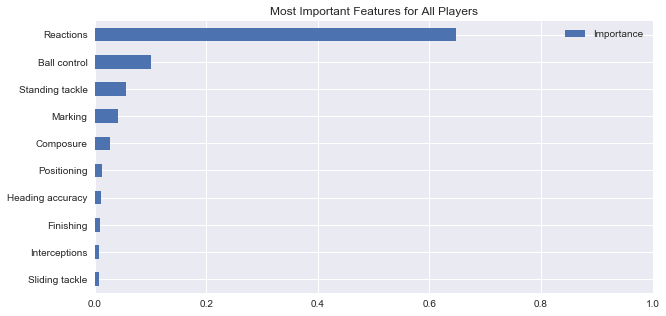

In [0]:
features['all'].head(10).sort_values(by='Importance').plot(kind='barh', 
                                                  figsize=(10,5), 
                                                  xlim=[0,1], 
                                                  title='Most Important Features for All Players')

So `Reactions` turns out to be the single most imporant factor for all players, with `ball control` and `standing tackle` being secondary.   
But this assumes that the `Overall` rating is calculated using the same formula for **all** outfielders - surely strikers wouldn't need defending abilities to be rated highly?   
Let's investigate further.

## Important Player Attributes by Position

In [0]:
for position in ['Forward', 'Midfielder', 'Back']:
    
    print("Generating feature importance for {}".format(position))
    
    # get the data
    data = players[players['Preferred Positions Type'] == position][cols]
    X = data.drop(['Overall'], axis=1)
    y = data['Overall']       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    
    # fit the random forest
    forest = RandomForestRegressor(n_estimators=100, random_state=42)
    forest.fit(X_train, y_train)
    feature_importance = forest.feature_importances_
    
    # save the resulting dataframe to a dictionary
    features[position] = pd.DataFrame(feature_importance, 
                                     X.columns, 
                                     columns=['Importance']).sort_values(by='Importance', ascending=False)
    

Generating feature importance for Forward
Generating feature importance for Midfielder
Generating feature importance for Back


Let's view the most important features for each position on a horizontal barplot.

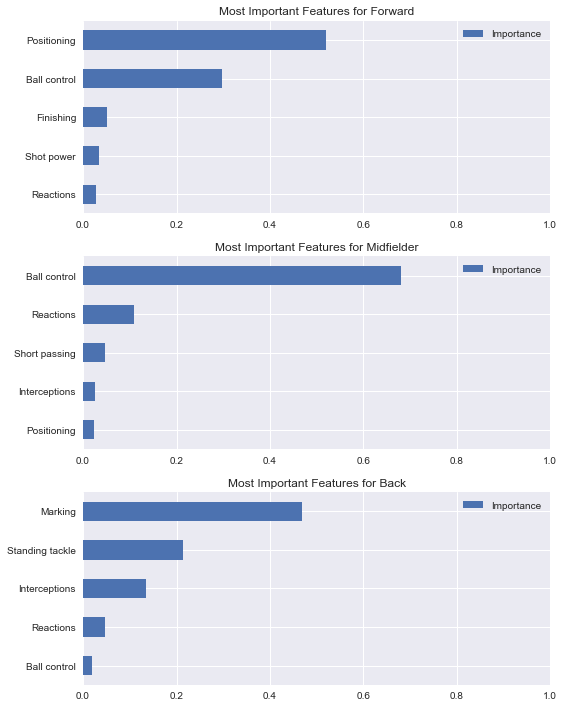

In [0]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

for i, position in enumerate(['Forward', 'Midfielder', 'Back']):
    features[position].head(5).sort_values(by='Importance').plot(kind='barh', xlim=[0,1], 
                                                  title='Most Important Features for {}'.format(position), ax=ax[i])
plt.tight_layout()

### Comparing running time

Now that we have the most important features for predicting the `Overall` rating, let's see how we can use this additional information to improve the performance of a K Nearest Neighbours regression model.

In [0]:
# Create reduced feature set containing only the 10 most important features
X_train_reduced = X_train[['Reactions', 'Ball control', 'Standing tackle', 'Marking', 'Composure', 'Positioning', 'Heading accuracy', 'Finishing', 'Interceptions', 'Sliding tackle']]
X_test_reduced = X_test[['Reactions', 'Ball control', 'Standing tackle', 'Marking', 'Composure', 'Positioning', 'Heading accuracy', 'Finishing', 'Interceptions', 'Sliding tackle']]

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [0]:
# Define full model
full_knn = KNeighborsRegressor(n_neighbors=5)

# Fit full model
full_knn.fit(X_train, y_train)

# Time fit
%timeit full_knn.fit(X_train, y_train)

100 loops, best of 3: 17.3 ms per loop


In [0]:
# Define reduced model
reduced_knn = KNeighborsRegressor(n_neighbors=5)

# Fit reduced model
reduced_knn.fit(X_train_reduced, y_train)

# Time fit
%timeit reduced_knn.fit(X_train_reduced, y_train)

100 loops, best of 3: 8.12 ms per loop


The reduced model was about twice as fast as the full model. This improvement in computation time will increase with the total number of features in our full model.

### Comparing predictive power
Now let's see how the reduced model performs on the test set compared to the full model.

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
# Get predictions
pred_full = full_knn.predict(X_test)
pred_reduced = reduced_knn.predict(X_test_reduced)

# Print MSE's
print('Full Model:', mean_squared_error(y_test, pred_full))
print('Reduced Model:', mean_squared_error(y_test, pred_reduced))

Full Model: 3.16310880829
Reduced Model: 2.51742487047


The reduced model performed better on the testing set and required less time to compute!

## Limitations of feature selection using random forests

Random forests are a popular method for feature ranking, since they are so easy to apply: in general they require very little feature engineering and parameter tuning. But they come with their own drawbacks, such as: 

**1. With correlated features, strong features can end up with low scores.** 

When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. 

This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

**2. The method can be biased towards variables with many categories or continuous variables with a large scale.** 

There is no effect in the mean values of the distributions of the permutation importance measures, which are in mean close to zero as expected for uninformative variables. However, the notable differences in the variance of the distributions for predictor variables with different scale of measurement or number of categories seriously affect the expressiveness of the variable importance measure.

This effect may lead to a severe over- or underestimation of the variable importance of variables that have more categories or a larger scale as an artefact of the method, even though they are no more or less informative than the other variables. 